In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from itertools import combinations

import warnings

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.stats_maker import *

In [2]:
merged = pd.read_csv('../../data/housing2019.csv')

In [8]:
lst = []
for i in sorted(merged.columns):
    lst.append(i)
#lst

In [22]:
merged['Sqft'] = merged['SqFtTotLiving'] + merged['SqFtFinBasement'] + merged['SqFtDeck']
trimmed = merged[(merged['SqFtTotLiving'] < 50000)]
sqft = trimmed['BldgGrade']
price = trimmed['SalePrice']

In [23]:
trimmed.shape

(29621, 157)

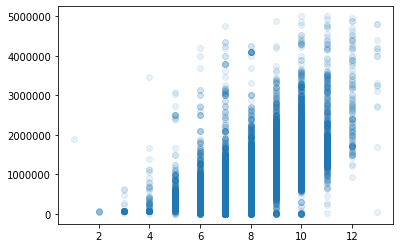

In [24]:
x = np.linspace(0, 10000, num = 1000)
y = x * 187.7 + 1.248 * 10 ** 4
plt.scatter(sqft, price, alpha = 0.1)
# plt.plot(x, y, color = 'r')

In [25]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving + BldgGrade", data=trimmed).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                 1.013e+04
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:47:16   Log-Likelihood:            -4.2409e+05
No. Observations:               29621   AIC:                         8.482e+05
Df Residuals:                   29618   BIC:                         8.482e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.115e+05   1.76e+04    -46.205      0.000   -8.46e+05   -7.77e+05
SqFtTotLiving   168.0636      3.353     50.118      0.000     161.491     174.636
BldgGrade      1.599e+05   2848.174     56.124      0.000    1.54e+05    1.65e+05
==============================================================================
Omnibus:                    17226.036   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           275527.570
Skew:                           2.487   Prob(JB):                         0.00
Kurtosis:                      17.089   Cond. No.                     1.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0012590253475246
Rainbow p-value: 0.4694881500948912


In [3]:
merged = merged.drop(labels = 'Unnamed: 0', axis = 1)

In [4]:
lst = []
for i in merged.columns:
    for j in merged.columns:
        if i == j: continue  
        try:
            rows = merged[[i, j]].values

            vif_df = pd.DataFrame()
            vif_df["VIF"] = [variance_inflation_factor(rows, k) for k in range(2)]
            vif_df["feature"] = [i, j]

            lst.append(vif_df)
            break
        except:
            pass

In [5]:
# this if for cutting the df down to only things that have valid vif's and drops a bunch of other stuff
# not sure why I did this. I think its kinda dumb
# It also aggregates waterfront columns and view columns into 1
dfi = lst[0]
for i in lst[1:]:
    dfi = pd.concat([dfi, i], axis = 0)
vif_able_columns = dfi['feature'].unique()
df_vif_only = merged[vif_able_columns]

df_vif_only['Wfnt'] = ((df_vif_only['WfntLocation'] != 0)
                        + (df_vif_only['WfntFootage'] != 0)
                        + (df_vif_only['WfntBank'] != 0)
                        + (df_vif_only['WfntPoorQuality'] != 0)
                        + (df_vif_only['WfntRestrictedAccess'] != 0)).astype(int)
df_vif_only = df_vif_only.drop(labels = ['WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess'], axis = 1)

view_cols = ['MtRainier', 'Olympics', 'Cascades', 'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView']
view_series = pd.Series(np.zeros(df_vif_only.shape[0]))
for i in view_cols:
    view_series = view_series + df_vif_only[i]
view_series = view_series.astype(int)
df_vif_only['ViewNumber'] = view_series
df_vif_only = df_vif_only.drop(view_cols, axis = 1)

#Get rid of some sqft columns i dont want
sqft_cols = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
             'SqFtUnfinHalf', 'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement']
df_vif_only = df_vif_only.drop(sqft_cols, axis = 1)

#Get rid of locational IDs
location_cols = ['Range',
                 #'Township',
                 'Section',
                 #'Area',
                 'SubArea',
                 'LevyCode']
df_vif_only = df_vif_only.drop(location_cols, axis = 1)


other_cols = ['Major_x', 'Minor_x', 'HBUAsIfVacant', 'HBUAsImproved', 'PresentUse', 'Major_y', 'Minor_y', 'Major', 'Minor']
df_vif_only = df_vif_only.drop(other_cols, axis = 1)
df_vif_only.columns

Index(['Township', 'Area', 'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access',
       'Topography', 'StreetSurface', 'RestrictiveSzShape',
       'InadequateParking', 'PcntUnusable', 'TidelandShoreland',
       'LotDepthFactor', 'TrafficNoise', 'AirportNoise', 'NbrBldgSites',
       'Contamination', 'HistoricSite', 'CurrentUseDesignation', 'pin',
       'ExciseTaxNbr', 'SalePrice', 'PropertyType', 'PrincipalUse',
       'SaleInstrument', 'SaleReason', 'PropertyClass', 'BldgNbr',
       'NbrLivingUnits', 'Stories', 'BldgGrade', 'BldgGradeVar',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtGarageAttached',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'Bedrooms', 'BathHalfCount',
       'Bath3qtrCount', 'BathFullCount', 'FpSingleStory', 'FpMultiStory',
       'FpFreestanding', 'FpAdditional', 'YrBuilt', 'YrRenovated',
       'PcntComplete', 'Obsolescence', 'PcntNetCondition', 'Condition',
       'AddnlCost', 'Wfnt', 'ViewNumber

In [6]:
using_columns = ['Wfnt', 'ViewNumber', 'SqFtTotLiving', 'SqFtOpenPorch',
                          'SqFtEnclosedPorch', 'SqFtDeck', 'Bedrooms', 'BathHalfCount',
                          'Bath3qtrCount', 'BathFullCount',
                          'TrafficNoise', 'Stories', 'Condition', 'Area',
                          'WaterSystem', 'SewerSystem', 'YrBuilt',
                          'YrRenovated', 'BldgGrade', 'Township']
two = stats_of_combinations(df_vif_only, 2)
#two = stats_of_combinations(df_vif_only, 2, using_columns)
#three = stats_of_combinations(df_vif_only, 3, using_columns)
#four = stats_of_combinations(df_vif_only, 4, using_columns)
srtd = sort_by_r2(two)

Combinations to go through: 1596
Percent Done: 0
Percent Done: 10
Percent Done: 20
Percent Done: 30
Percent Done: 40
Percent Done: 50
Percent Done: 60
Percent Done: 70
Percent Done: 80
Percent Done: 90
Percent Done: 100


In [200]:
srtd = sort_by_r2(four)
fltrd = filter_vf(srtd)

In [217]:
deef = pd.DataFrame()
for i in range(500):
    deef = deef.append(fltrd[i]['columns'])

In [218]:
deef[0].value_counts()

ViewNumber           225
SqFtOpenPorch        176
Bath3qtrCount        164
SqFtDeck             147
SqFtTotLiving        144
BathHalfCount        139
Wfnt                 136
YrRenovated          134
TrafficNoise         129
SqFtEnclosedPorch    129
BldgGrade            112
Area                 110
Township             100
BathFullCount         76
Condition             24
Bedrooms              19
Stories               17
SewerSystem           13
YrBuilt                3
WaterSystem            3
Name: 0, dtype: int64

In [216]:
fltrd[0]['ols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     5203.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:07:09   Log-Likelihood:            -4.2392e+05
No. Observations:               29621   AIC:                         8.479e+05
Df Residuals:                   29616   BIC:                         8.479e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.084e+06   1.58e+04    -68.425      0.000   -1.12e+06   -1.05e+06
ViewNumber     5.122e+04   1269.954     40.335      0.000    4.87e+04    5.37e+04
SqFtOpenPorch   394.5357     16.622     23.736      0.000     361.956     427.115
YrRenovated     115.8348      5.613     20.636      0.000     104.833     126.837
BldgGrade      2.334e+05   2095.289    111.404      0.000    2.29e+05    2.38e+05
==============================================================================
Omnibus:                    16664.013   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267788.762
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      16.945   Cond. No.                     2.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
using_columns = ['ViewNumber', 'BldgGrade', 'SqFtTotLiving', 'Wfnt', 'YrRenovated', 'SqFtOpenPorch', 'Bath3qtrCount', 
                 'TrafficNoise', 'SqFtDeck', 'Area', 'SqFtEnclosedPorch', 'BathHalfCount', 'SewerSystem', 'Condition', 'Bedrooms']
#one = stats_of_combinations(df_vif_only, 1, using_columns)
#two = stats_of_combinations(df_vif_only, 2, using_columns)
#three = stats_of_combinations(df_vif_only, 3, using_columns)

In [9]:
fltrd = filter_vf(sort_by_r2(three))

In [35]:
lst_thing = stats_of_combinations(df_vif_only, 10, using_columns)

Combinations to go through: 3003
Percent Done: 0
Percent Done: 10
Percent Done: 20
Percent Done: 30
Percent Done: 40
Percent Done: 50
Percent Done: 60
Percent Done: 70
Percent Done: 80
Percent Done: 90
Percent Done: 100


In [36]:
len(lst_thing)

20

In [38]:
sort_by_r2(lst_thing)[0]['ols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     2178.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:20:27   Log-Likelihood:            -4.2364e+05
No. Observations:               29621   AIC:                         8.473e+05
Df Residuals:                   29610   BIC:                         8.474e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.107e+06   1.67e+04    -66.482      0.000   -1.14e+06   -1.07e+06
ViewNumber         4.248e+04   1351.548     31.434      0.000    3.98e+04    4.51e+04
BldgGrade          2.318e+05   2342.911     98.922      0.000    2.27e+05    2.36e+05
Wfnt               2.442e+05   1.81e+04     13.467      0.000    2.09e+05     2.8e+05
YrRenovated         107.7805      5.579     19.320      0.000      96.846     118.715
SqFtOpenPorch       375.5415     16.710     22.475      0.000     342.790     408.293
Bath3qtrCount      5.254e+04   3563.998     14.743      0.000    4.56e+04    5.95e+04
TrafficNoise       3.171e+04   4035.412      7.858      0.000    2.38e+04    3.96e+04
SqFtDeck             61.4852     11.579      5.310      0.000      38.790      84.181
SqFtEnclosedPorch   102.9495     64.187      1.604      0.109     -22.860     228.759
BathHalfCount     -9867.1512   4776.656     -2.066      0.039   -1.92e+04    -504.694
==============================================================================
Omnibus:                    16173.806   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262738.947
Skew:                           2.273   Prob(JB):                         0.00
Kurtosis:                      16.864   Cond. No.                     3.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""